In [1]:
%load_ext autoreload
%autoreload 2

In [45]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import vice
from colorspacious import cspace_converter

# from surp.src.analysis import plotting_utils as pluto
from surp.src.analysis.apogee_analysis import subgiants

In [3]:
import arya
arya.save_at("./figures")


Bad key test.antialiased in file /home/daniel/python/arya/style/journal.mplstyle, line 14 ('test.antialiased:   False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution


In [40]:
def hex_to_rgb(h):
    return tuple(int(h[i:i+2], 16) for i in (1, 3, 5))

In [41]:
def to_lch(rgb):
    if type(rgb) is str:
        rgb = hex_to_rgb(rgb)
    return cspace_converter("sRGB255", "JCh")(rgb)

In [42]:
def to_hex(lch):
    r, g, b = to_rgb(lch)
    if any([round(x)>255 for x in [r,g,b]]):
        print("warning, out of range")
        print((r, g, b))
        s = round(max(r, g, b))/255
        r /= s
        g /= s
        b /= s
    return f"#{round(r):02x}{round(g):02x}{round(b):02x}"

In [43]:
def to_rgb(lch):
    a = lch
    a[2] = a[2] % 360
    return cspace_converter("JCh", "sRGB255")(lch)

In [61]:
rgb = [hex_to_rgb(h) for h in arya.style.COLORS]
rgb2 = [hex_to_rgb(h) for h in arya.style.cmap]
s = np.arange(10, 0, -1)

lab = to_lch(rgb)
lab2 = to_lch(rgb2)
plasma = to_lch([np.array(c)*256 for c in mpl.colormaps["plasma"].colors])


Text(0, 0.5, 'Chroma')

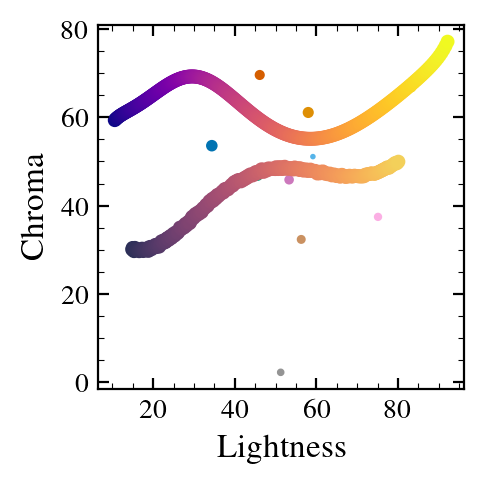

In [62]:
plt.scatter(lab[:, 0], lab[:, 1], c=arya.style.COLORS, s=s)
plt.scatter(lab2[:, 0], lab2[:, 1], c=[np.array(hex_to_rgb(h))/256 for h in arya.style.cmap])
plt.scatter(plasma[:, 0], plasma[:, 1], c=mpl.colormaps["plasma"].colors)

plt.xlabel("Lightness")
plt.ylabel("Chroma")

In [63]:
a = np.array([15,30,270])
b = np.array([80,50,90])

N = 3
dx = (b-a)/N
dx[2]*=-1

for i in range(N+1):
    c = a +i*dx
    if (c[2] > 360):
        c[2] -= 360
    print(c)
    print(to_hex(c))
    print("\n")


[ 15.  30. 270.]
#2b2f57


[ 36.66666667  36.66666667 330.        ]
#93598d


[58.33333333 43.33333333 30.        ]
#e78474


[80. 50. 90.]
#f4d15a




[]

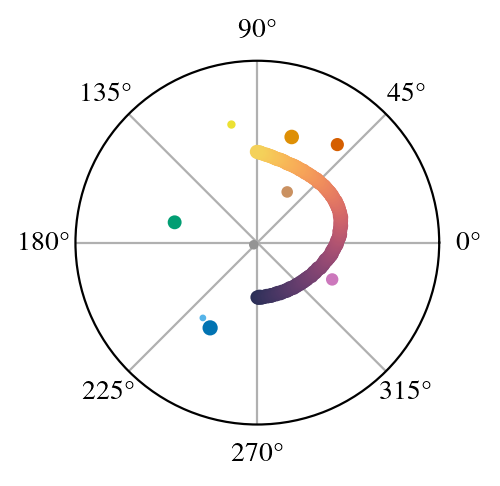

In [64]:
fig, ax = plt.subplots(subplot_kw={'projection':'polar'})

ax.scatter(lab[:, 2]/180*np.pi, lab[:, 1], c=arya.style.COLORS, s=2*s, zorder=2)
ax.scatter(lab2[:, 2]/180*np.pi, lab2[:, 1], c=arya.style.cmap, zorder=2)

ax.set_rmax(100)
ax.set_rlabel_position(0)
ax.set_rticks([])


one file saved at ./figures/subgiants_mgh.pdf


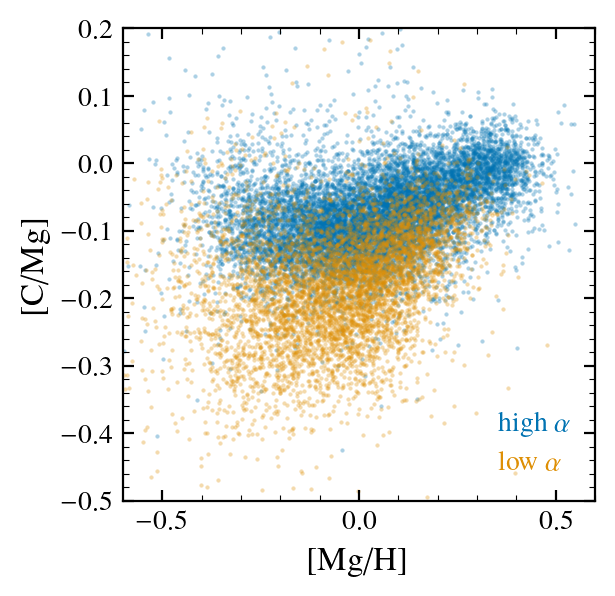

In [65]:
ha = subgiants["high_alpha"]

df = subgiants[~ha]

s = arya.Scatter(df["MG_H"], df["C_MG"], size=0.3, alpha=0.3)
s.label = "high $\\alpha$"

sp = s.subplot

df = subgiants[ha]
s1 = arya.Scatter(df["MG_H"], df["C_MG"], size=0.3, subplot=sp, alpha=0.3)
s1.label = "low $\\alpha$"


arya.Legend(sp)
sp.legend.ms = 2
cs = []
for c in sp.legend.colors:
    c1 = c
    c1[3] = 1
    cs.append(c1)
    
sp.legend.colors = cs
sp.legend.color_labels()
sp.legend.hide_handles()


sp.x.lim = (-0.6, 0.6)
sp.y.lim = (-0.5, 0.2)
sp.x.label = "[Mg/H]"
sp.y.label = "[C/Mg]"

sp.save("subgiants_mgh.pdf")

one file saved at ./figures/subgiants_mgfe.pdf


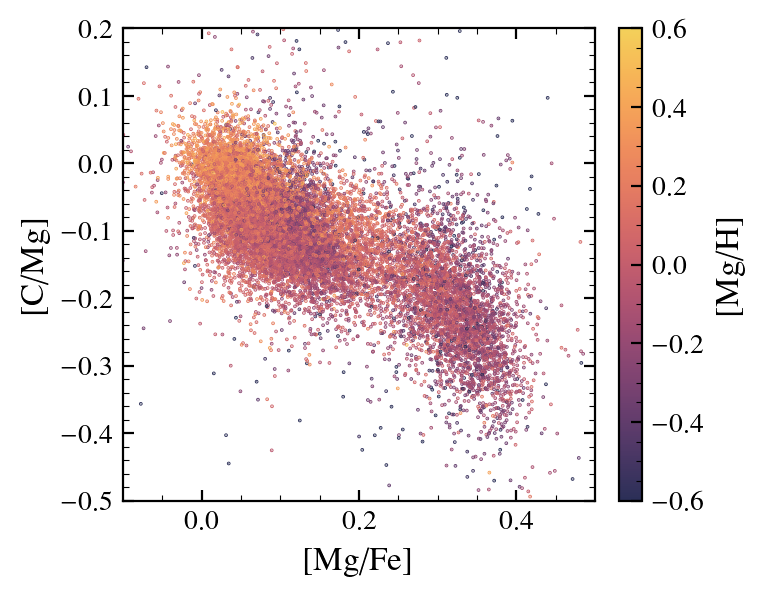

In [66]:
hanha = subgiants["high_alpha"]

df = subgiants
s = arya.Scatter(df["MG_FE"], df["C_MG"], s=0.1, alpha=1, c=df["MG_H"])
s.clim = (-0.6, 0.6)
s.label = "high $\\alpha$"

sp = s.subplot
cb = arya.Colorbar(s)
cb.ax.label = "[Mg/H]"

sp.x.lim = (-0.1, 0.5)
sp.y.lim = (-0.5, 0.2)
sp.x.label = "[Mg/Fe]"
sp.y.label = "[C/Mg]"

sp.save("subgiants_mgfe.pdf")


In [68]:

Z_max = 0.04
Z_min = 0.0001
logZ_min = np.log10(Z_min/0.014)
logZ_max = np.log10(Z_max/0.014)

norm = mpl.colors.Normalize(logZ_min, logZ_max)
cmap = arya.style.get_cmap()
mpp = mpl.cm.ScalarMappable(norm, cmap)
ma = mpp.to_rgba

AGB_MODELS = ["cristallo11", "karakas10", "ventura13", "karakas16"]
AGB_LABELS = ["C11+C15", "K10", "V13", "KL16+K18"]

# plt.rc('xtick.minor', visible=False)

def plot_c_table(study = "cristallo11", sp=None, label=None):

    y1, m1, z1 = vice.yields.agb.grid('c', study=study)
    N = len(z1)

    for i in range(N):
        y = np.array(y1)[:,i]
        z = z1[i]
        logz = np.log10(z) - np.log10(0.014)

        arya.Scatter(m1, y, label=f"Z = {z}", color=ma(logz), subplot=sp, zorder=i)
        arya.Line(m1, y, color=ma(logz), subplot=sp, zorder=i)

    plt.text(0.9, 0.9, label, horizontalalignment='right',
                   verticalalignment='top', transform=sp.mpl_ax.transAxes)
        # ax.set_xticks(np.arange(1, 8))
    
    # ax.axhline(0, color="k", ls="--", zorder=-1)



one file saved at ./figures/agb_yields.pdf


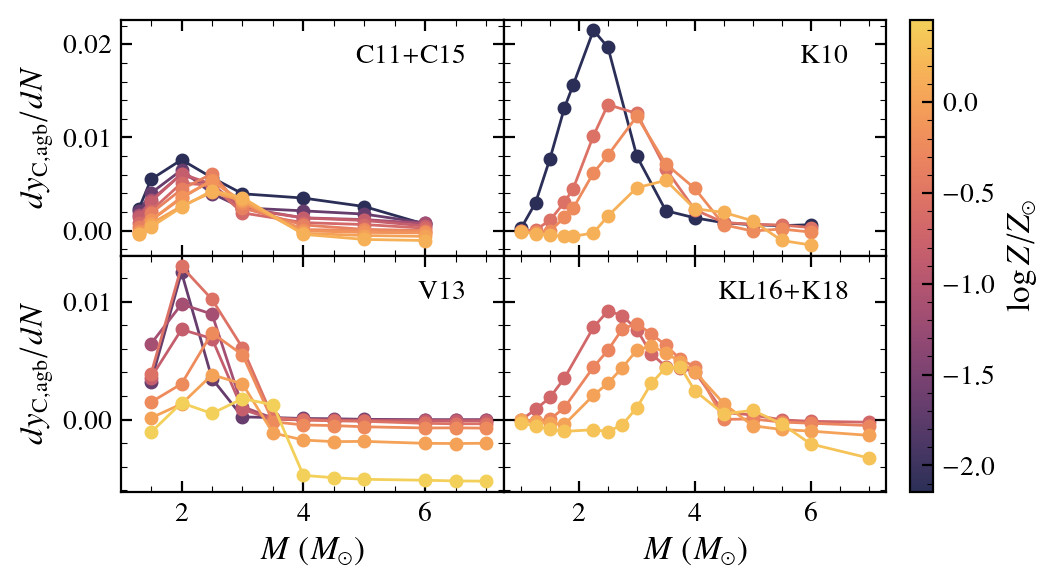

In [69]:
jp = arya.JoinPlot(2, 2, size=(3.822, 2.362))

for i in range(4):
    sp = jp.children[i//2][i%2]
    sp.x.label = r"$M\ (M_{\odot})$"
    sp.y.label = r"$dy_{\rm C, agb}/dN$"
    study = AGB_MODELS[i]
    label = AGB_LABELS[i]
    plot_c_table(study=study, sp=sp, label=label)
    
c = arya.Colorbar(subplot=jp, mappable = mpp, row=1, col=2, width=arya.Length(2.362*0.05))
c.ax.label = "$\log Z/Z_{\odot}$"

sp.save("agb_yields.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


one file saved at ./figures/y_agb_vs_t.pdf


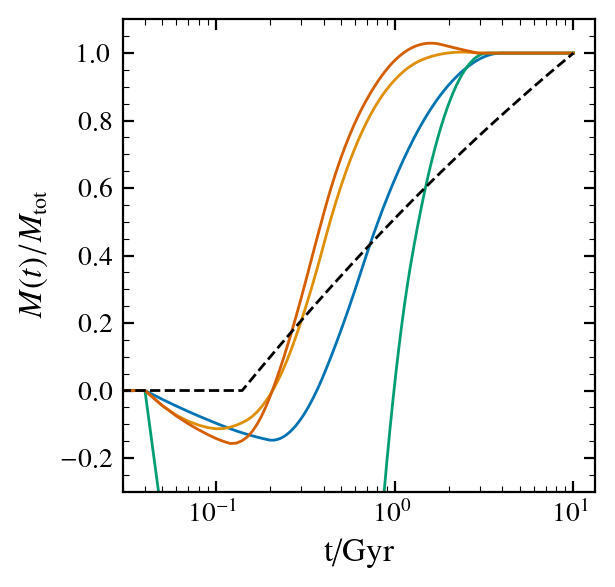

In [14]:
AGB_MODELS = ["cristallo11", "karakas10", "ventura13", "karakas16"]
AGB_LABELS = ["C11+C15", "K10", "V13", "KL16+K18"]
vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0

sp = arya.Subplot()

for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = model
    m_c, times = vice.single_stellar_population("c", Z=0.014 * 10**0)
    m_c = [c for c in m_c]
    arya.Line(times, np.array(m_c)/m_c[-1], subplot=sp)

m_fe, times = vice.single_stellar_population("fe", Z=0.014)
m_fe = [fe for fe in m_fe]
plt.plot(times, np.array(m_fe)/m_fe[-1], label="",
         linestyle="--", color="k")


plt.xlabel("t/Gyr")
plt.ylabel(r"$M(t)/M_{\rm tot}$")
plt.xscale("log")
plt.legend()
plt.ylim(-0.3, 1.1)
plt.xlim(0.03, 13.2)
sp.save("y_agb_vs_t.pdf")

one file saved at ./figures/y_agb_vs_z.pdf


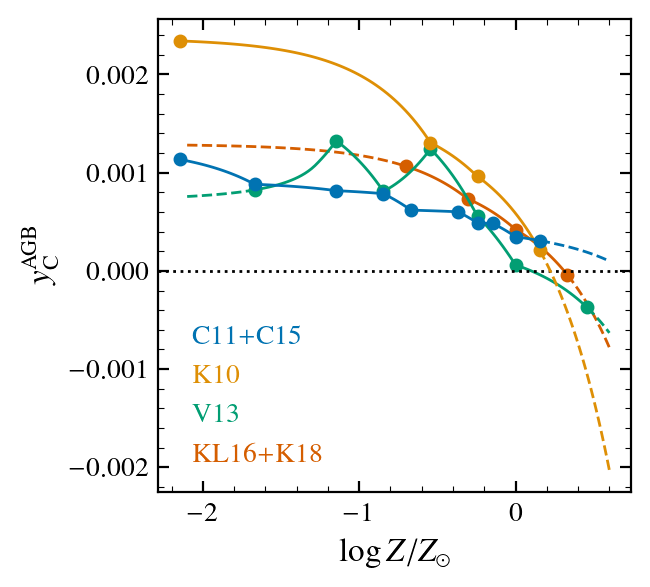

In [21]:
AGB_MODELS = ["cristallo11", "karakas10", "ventura13", "karakas16"]
AGB_LABELS = ["C11+C15", "K10", "V13", "KL16+K18"]


sp = arya.Subplot()

for i in range(len(AGB_MODELS)):
    model = AGB_MODELS[i]

    vice.yields.agb.settings["c"] = model
    vice.yields.ccsne.settings["c"] = 0
    Zs = 0.014*10**np.linspace(-2, 1, 100)
    
    # plots importaint points
    if type(model) == str:
        y1, m1, z1 = vice.yields.agb.grid('c', study=model)
        Zs = np.array(z1)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
        
    y_c_agb = np.array(mass_yields)/1e6 
    y_o_cc = 0.015
    arya.Scatter(np.log10(Zs/0.014), y_c_agb, subplot=sp, zorder=4-i)
    
    
    MoverH_min = np.log10(min(Zs)/0.014)
    MoverH_max = np.log10(max(Zs)/0.014)
    
    Zs = 0.014*10**np.linspace(MoverH_min, MoverH_max, 100)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
        
    l = arya.Line(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), 
                  label=AGB_LABELS[i], subplot=sp, zorder=4-i)
    l.label = AGB_LABELS[i]

    Zs = 0.014*10**np.linspace(-2.1, MoverH_min, 100)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
    arya.Line(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), linestyle="--", 
              color=l.color, subplot=sp, zorder=4-i)

    Zs = 0.014*10**np.linspace(MoverH_max, 0.6, 100)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
    arya.Line(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), linestyle="--", 
              color=l.color, subplot=sp, zorder=4-i)

plt.axhline(0, color="k", ls=":")
plt.xlabel(r"$\log Z/Z_\odot$")
plt.ylabel(r"$y_\text{C}^\text{AGB}$")

leg = arya.Legend(sp, handlelength=0)
leg.hide_handles()
leg.color_labels()

sp.save("y_agb_vs_z.pdf")

/tmp/ipykernel_9425/151740905.py:44: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity,


one file saved at ./figures/y_c_cc.pdf


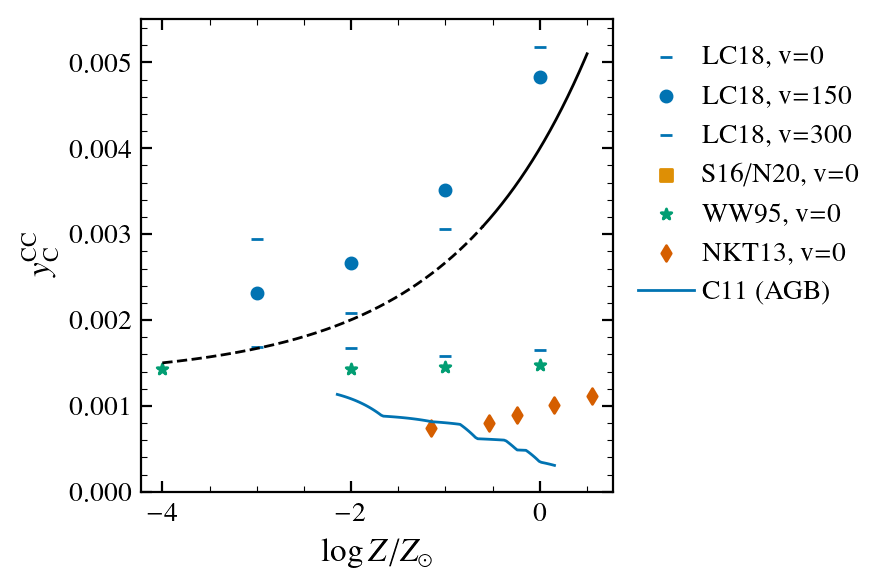

In [31]:
colors = arya.style.COLORS
# some studies have -inf values, which are ignored
allowed_MoverH = {
    "LC18": [-3, -2, -1, 0],
    "S16/N20": [0],
    #"CL13": [0],
    "NKT13": [-1.15, -0.54, -0.24, 0.15, 0.55],
    #"CL04": [-np.inf, -4, -2, -1, -0.37, 0.15],
    "WW95": [-4, -2, -1, 0]
    }

allowed_rotations = {
    "LC18": [0, 150, 300],
    "S16/N20": [0],
    "CL13": [0, 300],
    "NKT13": [0],
    "CL04": [0],
    "WW95": [0]
}

M_max = {
    "LC18": 120,
    "S16/N20": 120,
    "NKT13": 40,
    "WW95": 40,
    "CL04": 35,
    "CL13": 120,
}

ccsne_studies = ["LC18", "S16/N20", "WW95","NKT13"]

N = len(ccsne_studies)

sp = arya.Subplot()

for i in range(N):
    study=ccsne_studies[i]
    metalicities = allowed_MoverH[study]
    rotations = allowed_rotations[study]
    m_upper = M_max[study]
    
    for j in range(len(rotations)):
        rotation = rotations[j]
        y = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, 
            rotation=rotation, m_upper=m_upper)[0]
             for metalicity in metalicities]
        
        Z = list(map(lambda x: 10**x, metalicities))
        if rotation == 0:
            marker = ["_", "s", "*", "d"][i]
        elif rotation == 150:
            marker="o"
        elif rotation == 300:
            marker="_"
        plt.scatter(np.log10(Z), y, color=colors[i], label=f"{study}, v={rotation}", marker=marker)

    if len(rotations)>10:
        for metalicity in metalicities:
            plt.plot([metalicity]*len(rotations),
                     [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, 
            rotation=rotation, m_upper=m_upper)[0] for rotation in rotations],
                     color = colors[i], ls="--")

plt.ylim(0, 0.0055)

#plt.legend(bbox_to_anchor=(1,1), loc="upper left")

def y_c_cc(Z):
    return 0.004 *(0.5 + (Z/0.014)**0.3)/1.5

m_h = np.linspace(-0.6, 0.5, 1000)
Z = 0.014*10**m_h
plt.plot(m_h, y_c_cc(Z), color="k")

# plot AGB line

vice.yields.agb.settings["c"] = "cristallo11"
vice.yields.ccsne.settings["c"] = 0
Zs = 0.014*10**np.linspace(-2, 1, 100)

# plots importaint points
y1, m1, z1 = vice.yields.agb.grid('c', study="cristallo11")
Zs = np.array(z1)
mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])
    
y_c_agb = np.array(mass_yields)/1e6 
y_o_cc = 0.015
# plt.scatter(np.log10(Zs/0.014), y_c_agb)
MoverH_min = np.log10(min(Zs)/0.014)
MoverH_max = np.log10(max(Zs)/0.014)

Zs = 0.014*10**np.linspace(MoverH_min, MoverH_max, 100)
mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])
line, = plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), label="C11 (AGB)")

color = line.get_color()

m_h = np.linspace(-4, -0.6, 1000)
Z = 0.014*10**m_h
plt.plot(m_h, y_c_cc(Z), color="k", ls="--")

plt.legend(bbox_to_anchor=(1,1), loc="upper left")

#x = np.linspace(-4, 1)
#y = y_cc(0.014*10**x)
#plt.plot(x, y)
plt.xlabel(r"$\log Z/Z_\odot$")
plt.ylabel(r"$y_{\rm C}^{\rm CC}$")

sp.save("y_c_cc.pdf")

/tmp/ipykernel_9425/2064657249.py:46: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional('mg', study=study, MoverH=metalicity,


one file saved at ./figures/y_co_cc.pdf


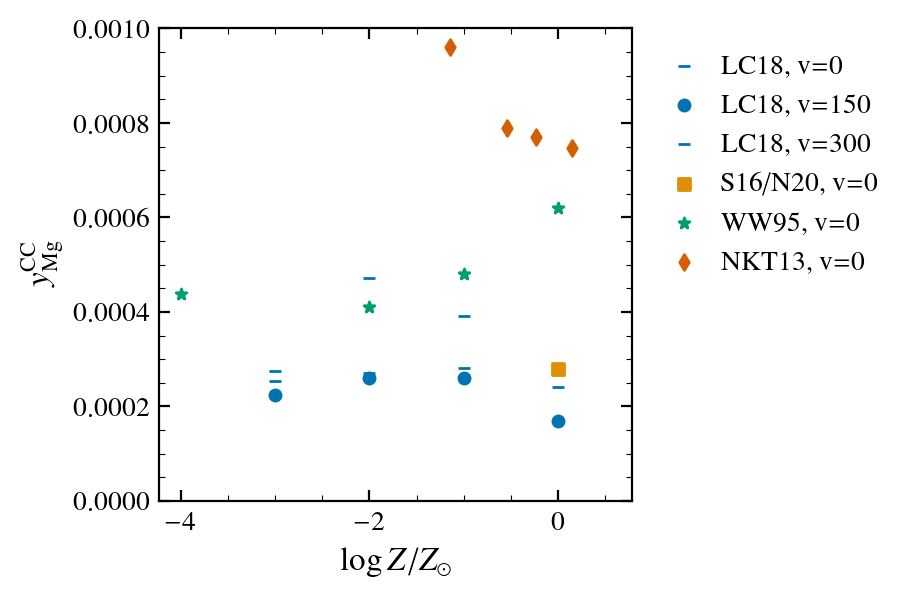

In [32]:
colors = arya.style.COLORS
# some studies have -inf values, which are ignored

sp = arya.Subplot()

allowed_MoverH = {
    "LC18": [-3, -2, -1, 0],
    "S16/N20": [0],
    #"CL13": [0],
    "NKT13": [-1.15, -0.54, -0.24, 0.15, 0.55],
    #"CL04": [-np.inf, -4, -2, -1, -0.37, 0.15],
    "WW95": [-4, -2, -1, 0]
    }

allowed_rotations = {
    "LC18": [0, 150, 300],
    "S16/N20": [0],
    "CL13": [0, 300],
    "NKT13": [0],
    "CL04": [0],
    "WW95": [0]
}

M_max = {
    "LC18": 120,
    "S16/N20": 120,
    "NKT13": 40,
    "WW95": 40,
    "CL04": 35,
    "CL13": 120,
}

ccsne_studies = ["LC18", "S16/N20", "WW95","NKT13"]

N = len(ccsne_studies)


for i in range(N):
    study=ccsne_studies[i]
    metalicities = allowed_MoverH[study]
    rotations = allowed_rotations[study]
    m_upper = M_max[study]
    
    for j in range(len(rotations)):
        rotation = rotations[j]
        y = [vice.yields.ccsne.fractional('mg', study=study, MoverH=metalicity, 
            rotation=rotation, m_upper=m_upper)[0]
             for metalicity in metalicities]
        
        Z = list(map(lambda x: 10**x, metalicities))
        if rotation == 0:
            marker = ["_", "s", "*", "d"][i]
        elif rotation == 150:
            marker="o"
        elif rotation == 300:
            marker="_"
        plt.scatter(np.log10(Z), y, color=colors[i], label=f"{study}, v={rotation}", marker=marker)


plt.ylim(0, 0.001)

#plt.legend(bbox_to_anchor=(1,1), loc="upper left")



plt.legend(bbox_to_anchor=(1,1), loc="upper left")

#x = np.linspace(-4, 1)
#y = y_cc(0.014*10**x)
#plt.plot(x, y)
plt.xlabel(r"$\log Z/Z_\odot$")
plt.ylabel(r"$y_{\rm Mg}^{\rm CC}$")

sp.save("y_co_cc.pdf")

/tmp/ipykernel_9425/1026940022.py:11: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  yc = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity,
/tmp/ipykernel_9425/1026940022.py:14: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  yo = [vice.yields.ccsne.fractional('mg', study=study, MoverH=metalicity,


one file saved at ./figures/y_co_cc.pdf


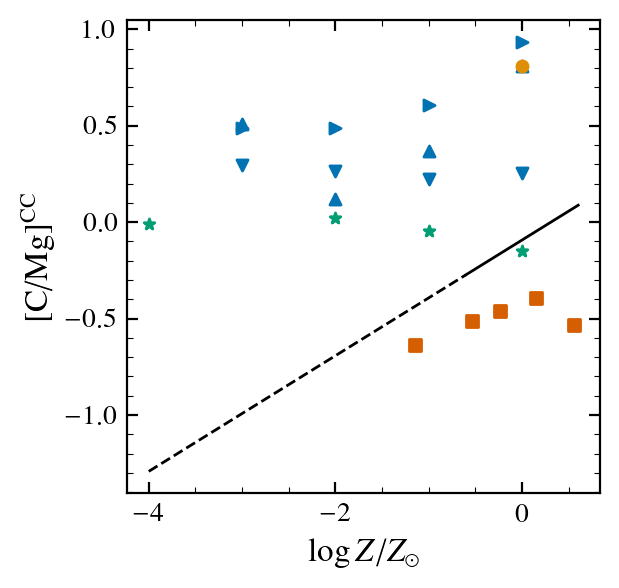

In [33]:
sp = arya.Subplot()

for i in range(len(ccsne_studies)):
    study=ccsne_studies[i]
    metalicities = allowed_MoverH[study]
    rotations = allowed_rotations[study]
    m_upper = M_max[study]
    
    for j in range(len(rotations)):
        rotation = rotations[j]
        yc = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, 
            rotation=rotation, m_upper=m_upper)[0]
             for metalicity in metalicities]
        yo = [vice.yields.ccsne.fractional('mg', study=study, MoverH=metalicity, 
            rotation=rotation, m_upper=m_upper)[0]
              for metalicity in metalicities]
        y = np.log10(np.array(yc)/yo) - np.log10(vice.solar_z("c")/vice.solar_z("mg"))
        
        Z = list(map(lambda x: 10**x, metalicities))
        if rotation == 0:
            marker = ["v", "o", "*", "s"][i]
        elif rotation == 150:
            marker=">"
        elif rotation == 300:
            marker="^"
        plt.scatter(np.log10(Z), y, color=colors[i], label=f"{study}, v={rotation}", marker=marker)


# plot model ...
def y_c_cc(Z):
    return 0.005 * (Z/0.014)**0.3

m_h = np.linspace(-0.6, 0.6, 1000)
Z = 0.014*10**m_h
y = np.log10(y_c_cc(Z)/0.015) - np.log10(vice.solar_z("c")/vice.solar_z("o"))
plt.plot(m_h, y, color="k")

m_h = np.linspace(-4, -0.6, 1000)
Z = 0.014*10**m_h
y = np.log10(y_c_cc(Z)/0.015) - np.log10(vice.solar_z("c")/vice.solar_z("o"))
plt.plot(m_h, y, color="k", ls="--")


# final style things
plt.xlabel(r"$\log Z/Z_{\odot}$")
plt.ylabel(r"[C/Mg]$^\text{CC}$")

sp.save("y_co_cc.pdf")

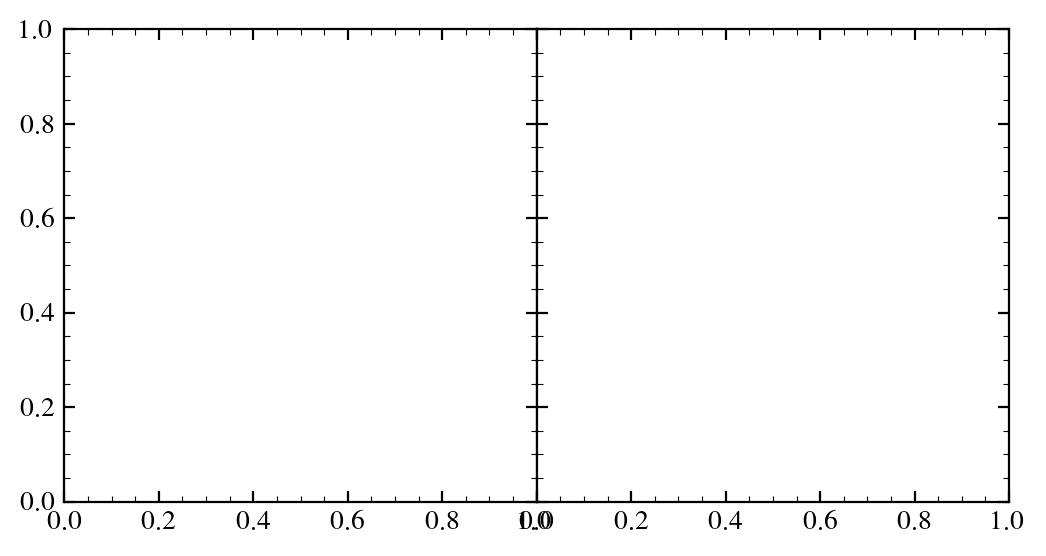

In [39]:
sp.x.ticks

[0, 0.2, 0.4, 0.6, 0.8]